In [6]:
#!/usr/bin/env python3

from diffusers import DiffusionPipeline
from diffusers import StableDiffusionLatentUpscalePipeline
from diffusers import DPMSolverMultistepScheduler
from PIL import Image

import torch


In [2]:

base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("mps")


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.59it/s]


In [3]:

base.scheduler = DPMSolverMultistepScheduler.from_config(base.scheduler.config)


In [4]:
prompt = "A majestic lion jumping from a big stone at night"

protoimages = base(
    prompt=prompt,
    num_inference_steps=40,
    num_images_per_prompt=3,
    denoising_end=0.8,
    output_type="latent",
).images


100%|██████████| 32/32 [03:21<00:00,  6.31s/it]


In [13]:

protocomp = Image.new('RGB', (3072, 1024))

x_offset = 0
for im in protoimages:
  protocomp.paste(im, (x_offset,0))
  x_offset += im.size[0]

protocomp

ValueError: cannot determine region size; use 4-item box

In [14]:

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
).to("mps")


Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 16.35it/s]


In [15]:

image = refiner(
    prompt=prompt,
    num_inference_steps=40,
    denoising_start=0.8,
    image=protoimages[2],
).images[0]

100%|██████████| 8/8 [00:19<00:00,  2.47s/it]


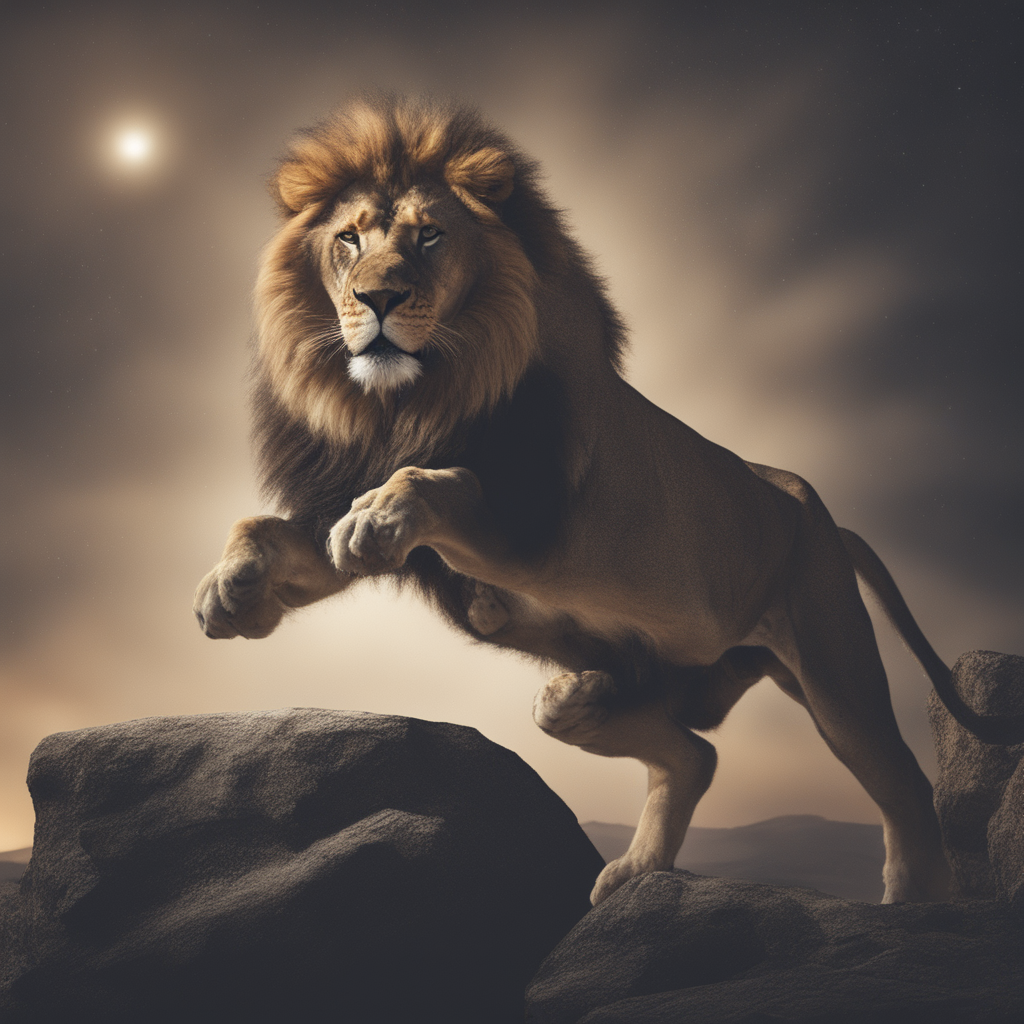

In [16]:
image